# Training a Diffractive Beam Splitter


In [ ]:
import torch
import torchoptics
import matplotlib.pyplot as plt
from torch.nn import Parameter

from torchoptics import Field, System
from torchoptics.elements import PhaseModulator
from torchoptics.profiles import gaussian

In [ ]:
shape = 250
waist_radius = 150e-6
device = "cuda" if torch.cuda.is_available() else "cpu"

torchoptics.set_default_spacing(10e-6)
torchoptics.set_default_wavelength(700e-9)

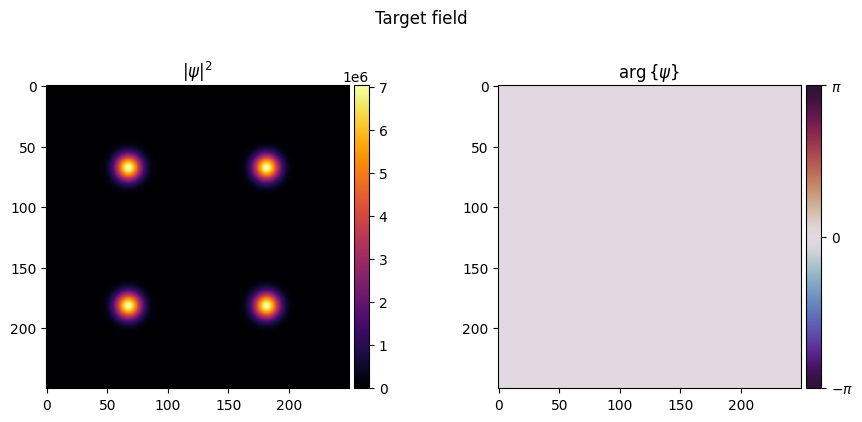

In [ ]:
target_field_data = (
    gaussian(shape, waist_radius, offset=(3.8 * waist_radius, 3.8 * waist_radius))
    + gaussian(shape, waist_radius, offset=(3.8 * waist_radius, -3.8 * waist_radius))
    + gaussian(shape, waist_radius, offset=(-3.8 * waist_radius, 3.8 * waist_radius))
    + gaussian(shape, waist_radius, offset=(-3.8 * waist_radius, -3.8 * waist_radius))
) / 2
target_field = Field(target_field_data, z=0.6).to(device)

target_field.visualize(title="Target field")

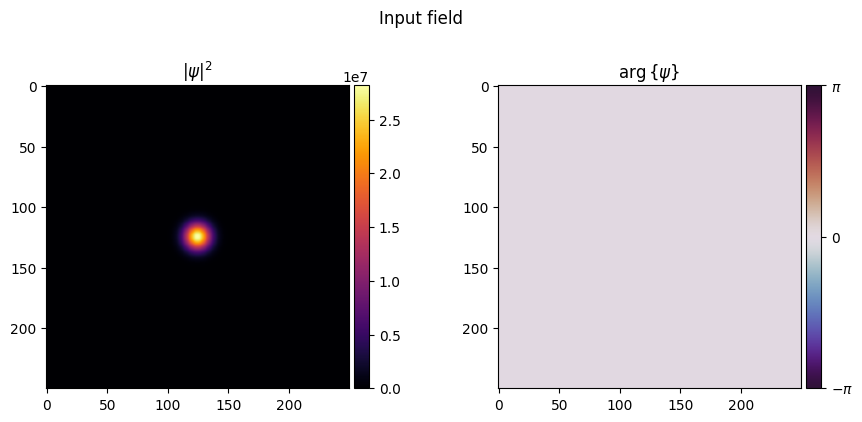

In [ ]:
input_field = Field(gaussian(shape, waist_radius), z=0).to(device)
input_field.visualize(title="Input field")

In [ ]:
system = System(
    PhaseModulator(Parameter(torch.zeros(shape, shape)), z=0.0),
    PhaseModulator(Parameter(torch.zeros(shape, shape)), z=0.2),
    PhaseModulator(Parameter(torch.zeros(shape, shape)), z=0.4),
).to(device)

In [ ]:
optimizer = torch.optim.Adam(system.parameters(), lr=0.1)
losses = []
for iteration in range(400):
    optimizer.zero_grad()
    output_field = system.measure_at_z(input_field, 0.6)
    loss = 1 - output_field.inner(target_field).abs().square()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss {loss.item()}")

Iteration 0, Loss 0.9784589364195946
Iteration 10, Loss 0.5717267585639523
Iteration 20, Loss 0.2815336160348716
Iteration 30, Loss 0.1319079693357137
Iteration 40, Loss 0.07754239474673286
Iteration 50, Loss 0.051543123503664745
Iteration 60, Loss 0.03715064886151531
Iteration 70, Loss 0.02834961446952
Iteration 80, Loss 0.021785695486420398
Iteration 90, Loss 0.016057424143190113
Iteration 100, Loss 0.011977746351145013
Iteration 110, Loss 0.009444077022033315
Iteration 120, Loss 0.008084402492947729
Iteration 130, Loss 0.007148053046765801
Iteration 140, Loss 0.006397778150560751
Iteration 150, Loss 0.005732558499186413
Iteration 160, Loss 0.005136623763173698
Iteration 170, Loss 0.004607192743092847
Iteration 180, Loss 0.004142376633131217
Iteration 190, Loss 0.0037900176110389205
Iteration 200, Loss 0.003521664216524223
Iteration 210, Loss 0.0033207133301014213
Iteration 220, Loss 0.0031600099784474533
Iteration 230, Loss 0.0030476268327582767
Iteration 240, Loss 0.002980907650470

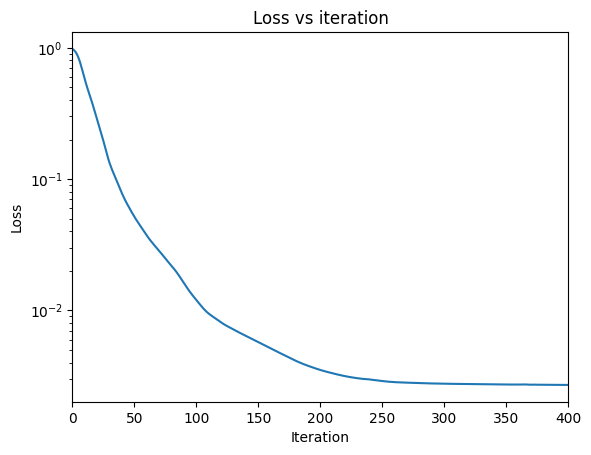

In [ ]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs iteration")
plt.yscale("log")
plt.xlim(0, len(losses))
plt.show()

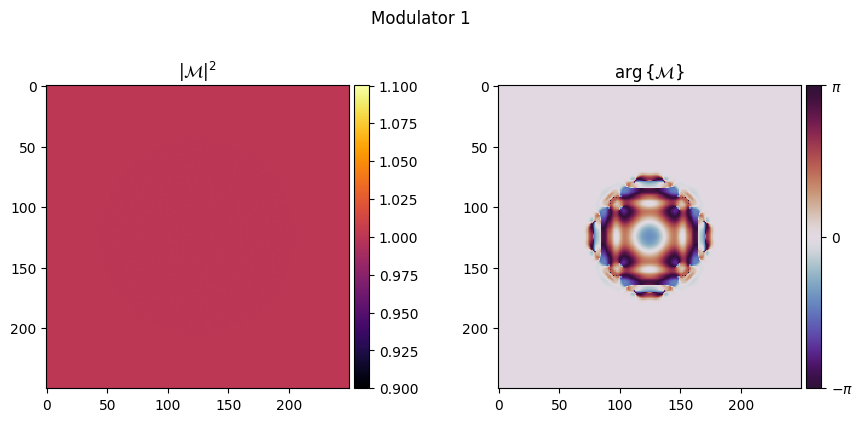

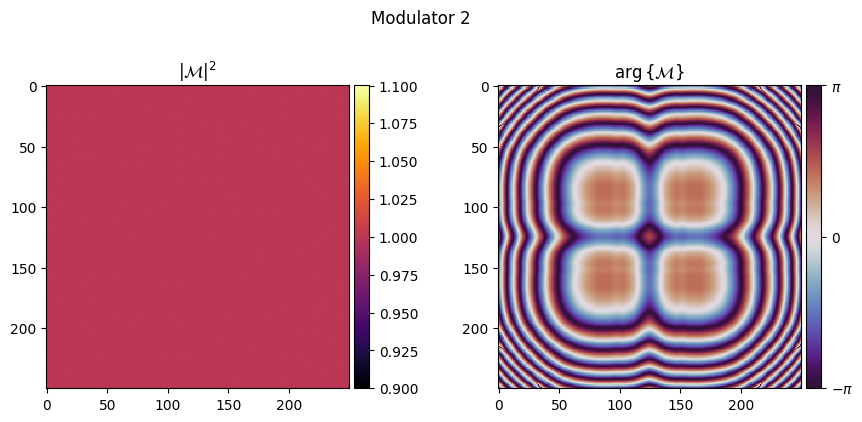

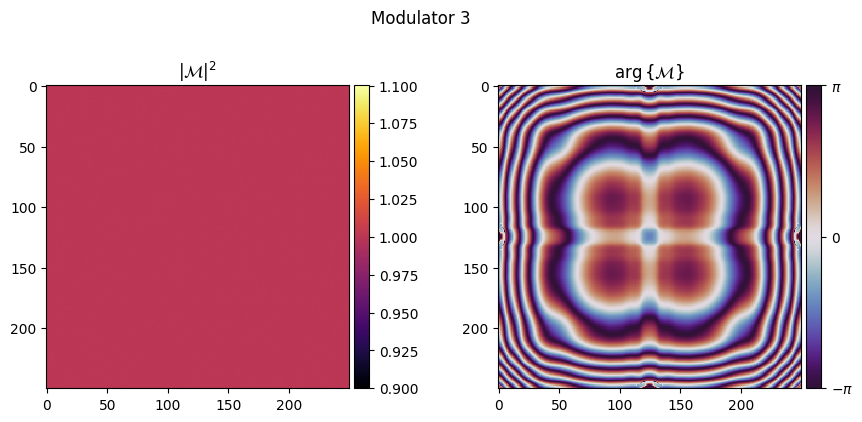

In [ ]:
for i, element in enumerate(system):
    element.visualize(title=f"Modulator {i+1}")

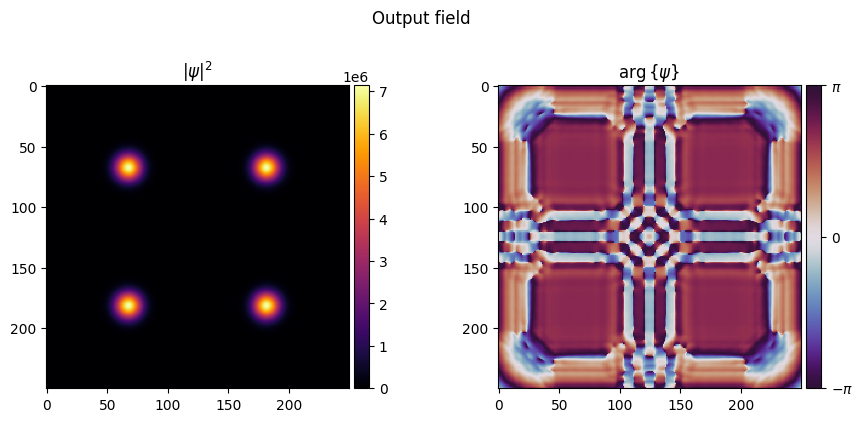

In [ ]:
output_field = system.measure_at_z(input_field, 0.6)
output_field.visualize(title="Output field")